<p align="center">
    <img width="1000" height="500" src="https://whatsupnewp.com/wp-content/uploads/2020/03/banner.png"
</p>

# COVID-19 Open Research Dataset Challenge (CORD-19)
## An AI challenge with AI2, CZI, MSR, Georgetown, NIH & The White House

#### Dataset Description:
In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 29,000 scholarly articles, including over 13,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.

In [64]:
# importing required libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer,PorterStemmer
from wordcloud.wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.cluster import DBSCAN
from nltk.corpus import stopwords
from collections import  Counter
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import pyLDAvis.gensim
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import pyLDAvis
import gensim
import spacy
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import LatentDirichletAllocation as LDA
from PIL import Image


In [3]:
path = "2020-03-13/"
all_sources = pd.read_csv(path+"all_sources_metadata_2020-03-13.csv")
all_sources.head(2)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True


### EDA of common words and topics:

In [4]:
len(all_sources)

29500

In [5]:
all_sources.isna().sum()

sha                            12080
source_x                           0
title                            370
doi                             3143
pmcid                           2163
pubmed_id                      12770
license                        11808
abstract                        2947
publish_time                   11252
authors                          946
journal                        11709
Microsoft Academic Paper ID    28366
WHO #Covidence                 28264
has_full_text                  12080
dtype: int64

In [6]:
all_sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29500 entries, 0 to 29499
Data columns (total 14 columns):
sha                            17420 non-null object
source_x                       29500 non-null object
title                          29130 non-null object
doi                            26357 non-null object
pmcid                          27337 non-null object
pubmed_id                      16730 non-null float64
license                        17692 non-null object
abstract                       26553 non-null object
publish_time                   18248 non-null object
authors                        28554 non-null object
journal                        17791 non-null object
Microsoft Academic Paper ID    1134 non-null float64
WHO #Covidence                 1236 non-null object
has_full_text                  17420 non-null object
dtypes: float64(2), object(12)
memory usage: 3.2+ MB


In [7]:
all_sources.dtypes

sha                             object
source_x                        object
title                           object
doi                             object
pmcid                           object
pubmed_id                      float64
license                         object
abstract                        object
publish_time                    object
authors                         object
journal                         object
Microsoft Academic Paper ID    float64
WHO #Covidence                  object
has_full_text                   object
dtype: object

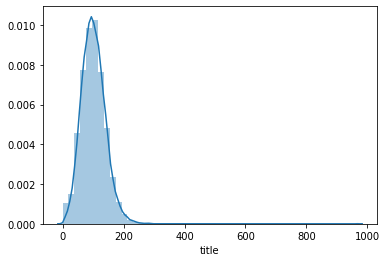

In [8]:
# distribution of title length
all_sources
headline_length = all_sources['title'].str.len()
headline_length = headline_length.fillna(0)
sns.distplot(headline_length)
plt.show()

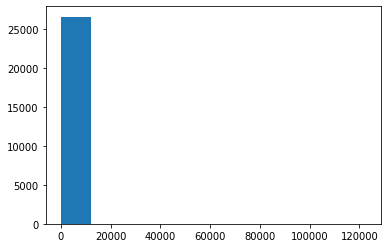

In [9]:
# distribution of abstract length
headline_length = all_sources['abstract'].str.len()
plt.hist(headline_length)
plt.show()

In [10]:
df = all_sources
stop=set(stopwords.words('english'))
def build_list(df, col):
    corpus=[]
    lem=WordNetLemmatizer()
    stop=set(stopwords.words('english'))
    new= df[col].dropna().str.split()
    new=new.values.tolist()
    corpus=[lem.lemmatize(word.lower()) for i in new for word in i if(word) not in stop]
    return corpus

In [11]:
build_list(df, "title")

['angiotensin-converting',
 'enzyme',
 '2',
 '(ace2)',
 'sars-cov-2',
 'receptor:',
 'molecular',
 'mechanism',
 'potential',
 'therapeutic',
 'target',
 'comparative',
 'genetic',
 'analysis',
 'novel',
 'coronavirus',
 '(2019-ncov/sars-cov-2)',
 'receptor',
 'ace2',
 'different',
 'population',
 'incubation',
 'period',
 'other',
 'epidemiological',
 'characteristic',
 '2019',
 'novel',
 'coronavirus',
 'infection',
 'right',
 'truncation:',
 'a',
 'statistical',
 'analysis',
 'publicly',
 'available',
 'case',
 'data',
 'characteristic',
 'public',
 'health',
 'response',
 'coronavirus',
 'disease',
 '2019',
 'outbreak',
 'china',
 'imaging',
 'change',
 'severe',
 'covid-19',
 'pneumonia',
 'an',
 'updated',
 'estimation',
 'risk',
 'transmission',
 'novel',
 'coronavirus',
 '(2019-ncov)',
 'real-time',
 'forecast',
 '2019-ncov',
 'epidemic',
 'china',
 'february',
 '5th',
 'february',
 '24th,',
 '2020',
 'retracted:',
 'chinese',
 'medical',
 'staff',
 'request',
 'international',

In [26]:
title = list(build_list(df, "title"))

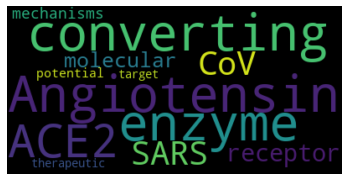

In [29]:
# Start with one review:
text = df.title[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

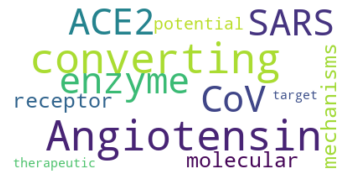

In [32]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [33]:
# Save the image in the img folder:
wordcloud.to_file("imgs/first_title.png")

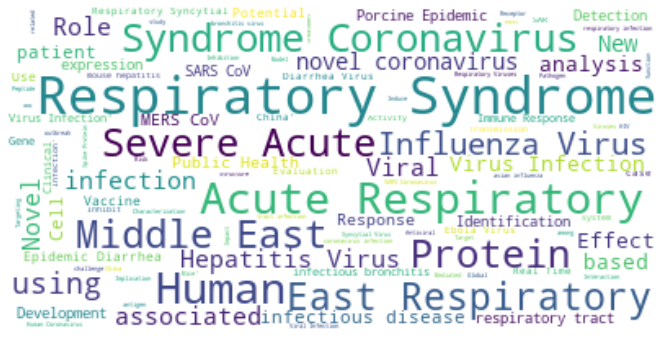

In [60]:
cleanedTitle = [x for x in df.title if str(x) != 'nan']
text = ''.join("".join(str(cleanedTitle)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [61]:
wordcloud.to_file("imgs/TitlesWC.png")

In [22]:
build_list(df, "abstract")

['the',
 'geographic',
 'spread',
 '2019',
 'novel',
 'coronavirus',
 '(covid-19)',
 'infection',
 'epicenter',
 'wuhan,',
 'china,',
 'provided',
 'opportunity',
 'study',
 'natural',
 'history',
 'recently',
 'emerged',
 'virus.',
 'using',
 'publicly',
 'available',
 'event-date',
 'data',
 'ongoing',
 'epidemic,',
 'present',
 'study',
 'investigated',
 'incubation',
 'period',
 'time',
 'interval',
 'govern',
 'epidemiological',
 'dynamic',
 'covid-19',
 'infections.',
 'our',
 'result',
 'show',
 'incubation',
 'period',
 'fall',
 'within',
 'range',
 '2&ndash;14',
 'day',
 '95%',
 'confidence',
 'mean',
 'around',
 '5',
 'day',
 'approximated',
 'using',
 'best-fit',
 'lognormal',
 'distribution.',
 'the',
 'mean',
 'time',
 'illness',
 'onset',
 'hospital',
 'admission',
 '(for',
 'treatment',
 'and/or',
 'isolation)',
 'estimated',
 '3&ndash;4',
 'day',
 'without',
 'truncation',
 '5&ndash;9',
 'day',
 'right',
 'truncated.',
 'based',
 '95th',
 'percentile',
 'estimate',
 'in

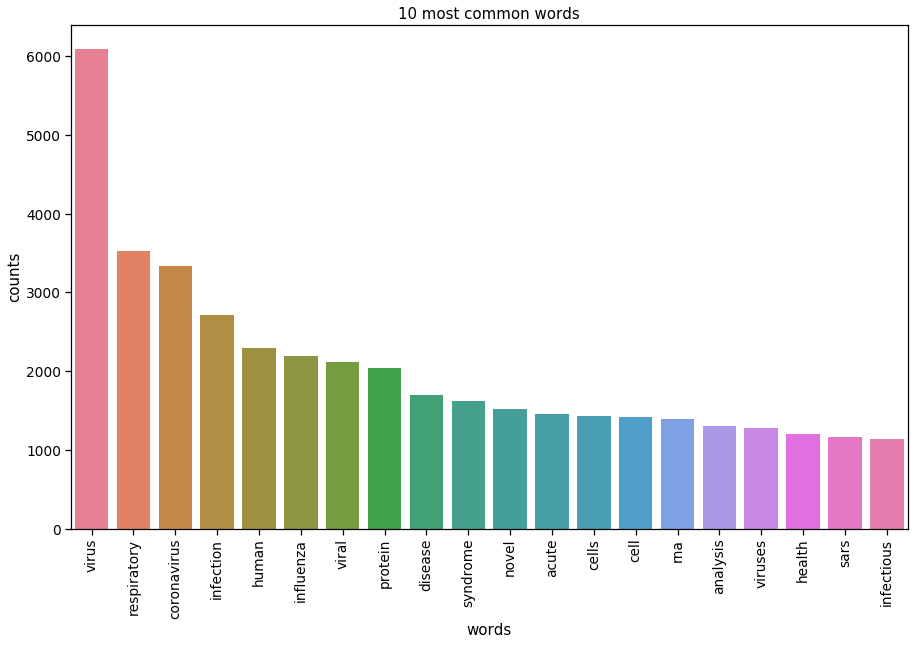

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
# Helper function
def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(cleanedTitle)
# Visualise the 10 most common words
plot_20_most_common_words(count_data, count_vectorizer)


In [67]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 20
number_words = 20
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
enterovirus contact patterns plant analysis endoplasmic reticulum large 71 disease scale network gene transmission model hiv spread dendritic malaria cells

Topic #1:
respiratory syndrome coronavirus acute severe east middle mers infection viruses cov bat reproductive saudi 2015 arabia sars korea protein human

Topic #2:
health disease infectious diseases influenza pandemic global public outbreak 19 review covid emerging care study sars transmission risk epidemic ebola

Topic #3:
2019 novel ncov coronavirus sequencing using gastroenteritis high evolution analysis transmissible virus throughput based china method wuhan approach different genome

Topic #4:
virus infection infectious coronavirus type cells protein influenza feline human bronchitis cell replication interferon like murine host inhibition activation avian

Topic #5:
novel coronavirus 2019 infection treatment pneumonia bats new strategies viral discovery therapeutic potential viruses preventio

In [69]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
# with open(LDAvis_data_filepath, 'w') as f:
#         pickle.dump(LDAvis_prepared, f)
        
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath) as f:
#     LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

IndentationError: expected an indented block (<unknown>, line 8)

In [ ]:
# dynamic UI
lda_display = pyLDAvis.gensim.prepare(lda_train, train_corpus, train_id2word, sort_topics=False)
#pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, 'LDA_40000_50topics.html')

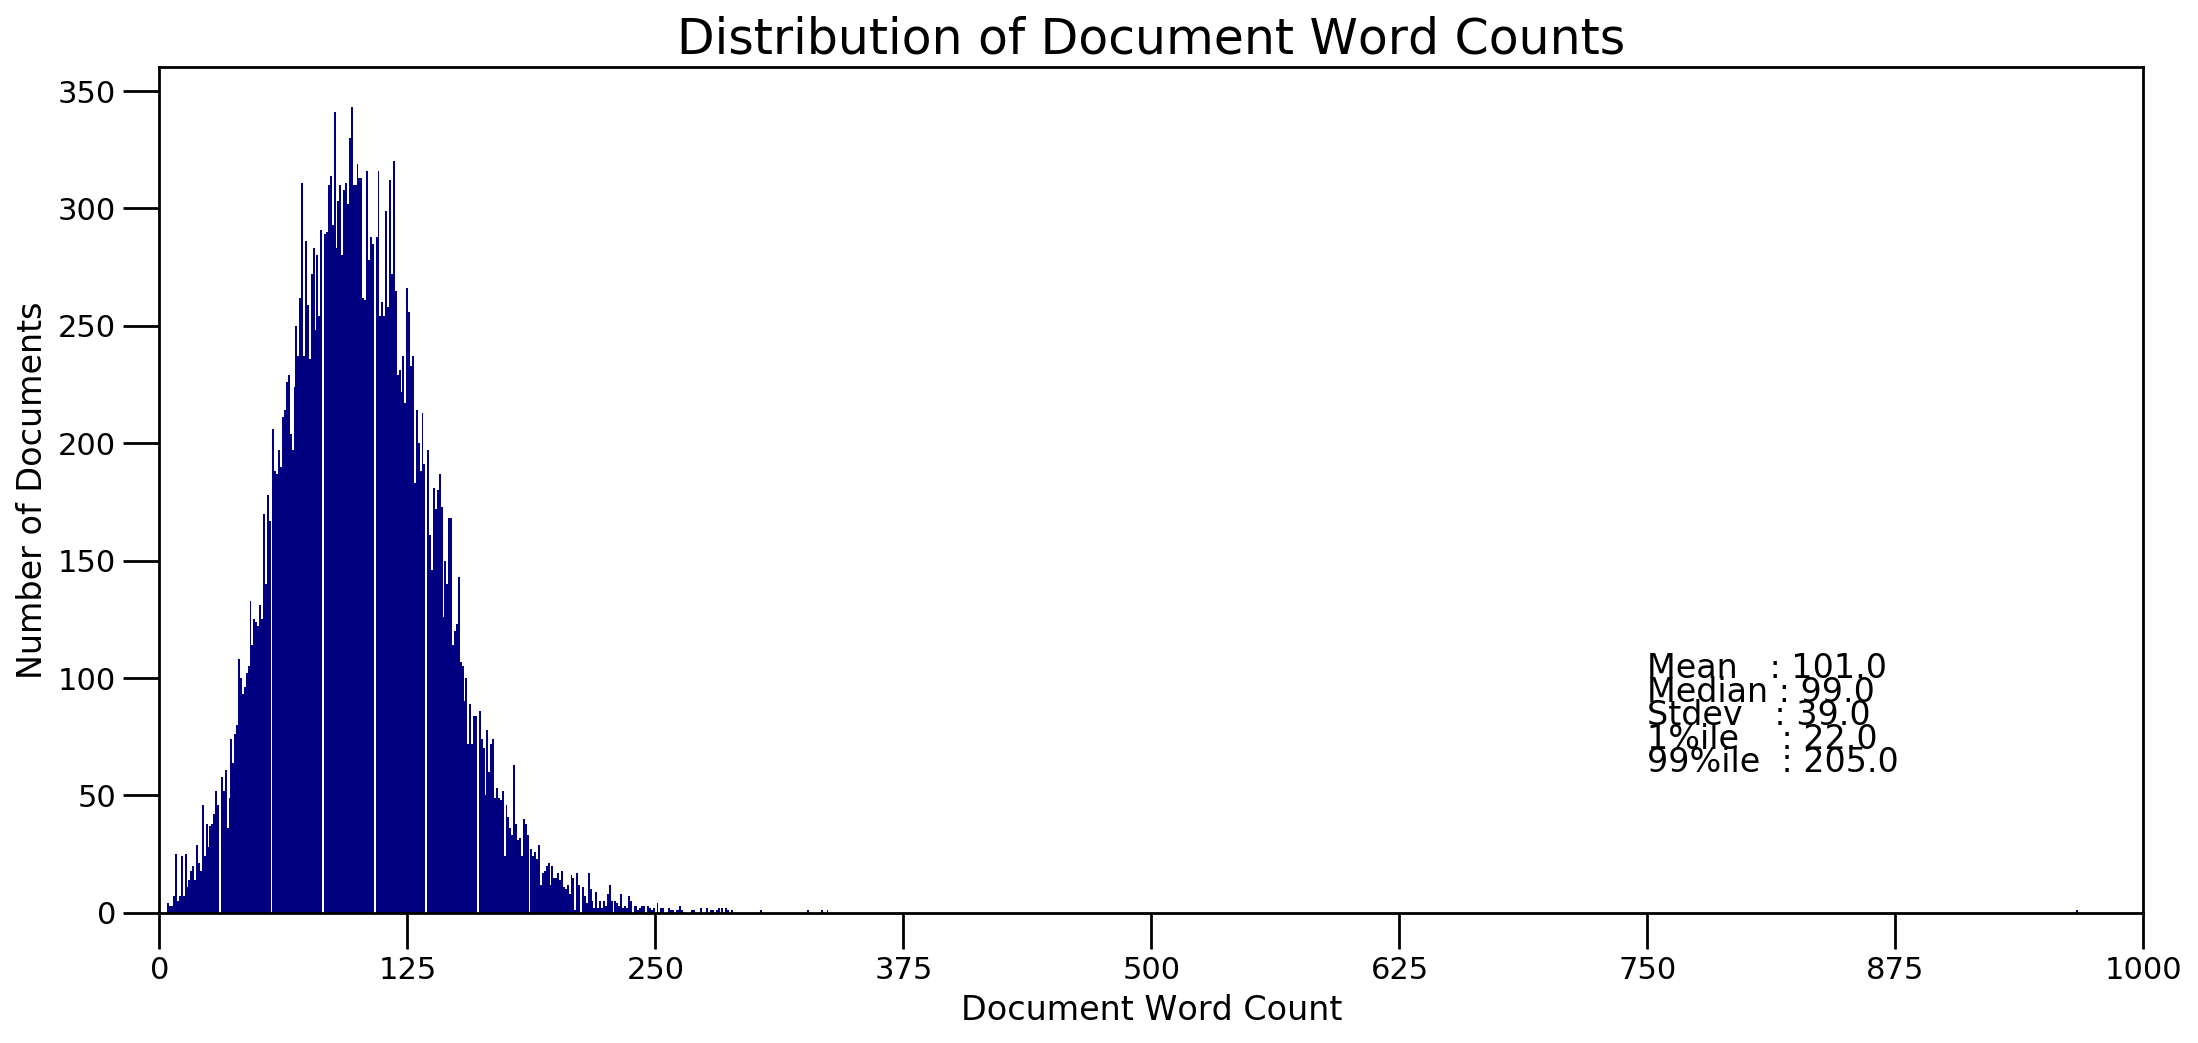

In [70]:
doc_lens = [len(d) for d in cleanedTitle]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()